In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pydantic import BaseModel, Field
from ipa.ppprof import perfprof

In [2]:
class OneExperimentResults(BaseModel):
    problemName: str = Field(description="Name of the problem")
    method: str = Field(description="Name of the method")
    runID: int = Field(description="Run number")
    hv: list[float] = Field(description="Hypervolume (Normalized) of the found solutions at each iteration")
    IDG: list[float] = Field("IGD of the found solutions at each iteration")
    RSE: list[float | None] = Field("ln(RSE) of the found solutions at each iteration")
    uniformity: list[float | None] = Field("Uniformity Level of the found solutions at each iteration")
    coverage: list[float] = Field("Coverage Error of the found solutions at each iteration")
    spacing: list[float | None] = Field("Spacing indicator value of the found solutions at each iteration")
    CumBadRefs: list[float] = Field(description="Cumulative fraction of bad reference points found at each iteration")
    success: list[bool] = Field(description="Whether the method evaluated a valid reference point at each iteration")
    runtime: float = Field(description="Runtime of the experiment")
    found_solutions: list[list[float]] = Field(description="Found solutions at each iteration")


class ExperimentResults(BaseModel):
    results: list[OneExperimentResults] = Field(description="Results of the experiment")

In [3]:
problems = [
    "dtlz5_3", "dtlz5_4", "dtlz5_5", "dtlz7", "forest1",
    "forest2", "forest3", "forest4", "nforest1", "nforest2",
    "nforest3", "forest", "nforest", "RE31", "RE32", "RE33",
    "RE34", "RE35", "RE36", "RE37", "RE41", "RE42", "RE61",
]

indicators = ["IGD", "coverage", "uniformity"]

In [4]:
def read_results(problem):
    root = "../results/"
    files = os.listdir(root)
    files = [f for f in files if problem in f]

    # read all the files
    f_results = []
    for f in files:
        with open(root + f, "r") as file:
            data = file.read()
            temp = OneExperimentResults.model_validate_json(data)
            if temp.problemName == problem:
                f_results.append(temp)

    f_pd = pd.DataFrame(
        columns=[
            "method",
            "runID",
            "iteration",
            "IGD",
            "uniformity",
            "coverage",
        ]
    )

    for r in f_results:
        to_add = pd.DataFrame(
            {
                "method": [r.method] * len(r.CumBadRefs),
                "runID": [r.runID] * len(r.CumBadRefs),
                "iteration": range(len(r.CumBadRefs)),
                "IGD": r.IDG + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "uniformity": r.uniformity,
                "coverage": r.coverage,
            }
        )
        f_pd = pd.concat([f_pd, to_add])
    f_pd_clean = (
        f_pd[["coverage", "uniformity", "IGD", "iteration", "method", "runID"]]
        .dropna()
        .pivot(index="iteration", columns=["method", "runID"], values=["coverage", "uniformity", "IGD"])
    )
    f_pd_clean = f_pd_clean.fillna(method="ffill")
    f_pd_clean = f_pd_clean.fillna(method="bfill")

    f_pd_clean = pd.melt(f_pd_clean.reset_index(), id_vars="iteration")
    f_pd_clean["metric"] = f_pd_clean[None]
    f_pd_clean = f_pd_clean.drop(columns=[None])
    # convert test to wide format by splitting metric column into two columns
    f_pd_clean = f_pd_clean.pivot(
        index=["iteration", "method", "runID"], columns="metric", values="value"
    ).reset_index()

    f_pd_clean = f_pd_clean.groupby(["method", "iteration"]).median().reset_index().drop(columns=["runID"])

    # Convert back to wide format
    f_pd_clean = f_pd_clean.pivot(index="iteration", columns="method", values=["IGD", "coverage", "uniformity"])
    #f_pd_clean.columns = [f"{x}_{y}" for x, y in f_pd_clean.columns]
    f_pd_clean = f_pd_clean.reset_index()
    f_pd_clean["problem"] = problem
    return f_pd_clean

In [5]:
data = pd.concat([read_results(p) for p in problems])

/tmp/bssainix/3812366/ipykernel_16055/897293590.py:39: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  f_pd[["coverage", "uniformity", "IGD", "iteration", "method", "runID"]]
/tmp/bssainix/3812366/ipykernel_16055/897293590.py:39: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  f_pd[["coverage", "uniformity", "IGD", "iteration", "method", "runID"]]
/tmp/bssainix/3812366/ipykernel_16055/897293590.py:50: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  f_pd_clean = f_pd_clean.pivot(
/tmp/bssainix/3812366/ipykernel_16055/897293590.py:39: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

In [6]:

def create_ppplot(data, metric, iteration = None, xlim=None, fig=None, ax=None, show_legend=False, show_ylabel=False, show_title=True):
    if iteration is not None:
        assert 0 < iteration < 500
    if fig is None:
        fig, ax = plt.subplots()
    metrics = {
        "IGD": "IGD Indicator",
        "uniformity": "Uniformity Level",
        "coverage": "Coverage Error",
    }
    test = data[[metric, "iteration", "problem"]]

    if metric == "uniformity":
        test["uniformity"] = 1 / test["uniformity"]

    test.columns = [y if y else x for x, y in test.columns]

    methods = [
            "DSS Pruned",
            "Random Pruned",
            "DSS",
            "Random",
        ]

    colormap = {
            "DSS Pruned": {"color":"#377eb8", "linestyle":"solid", "markevery":[0], "marker":"X"},
            "Random Pruned": {"color":"#984ea3", "linestyle":"solid", "markevery":[0], "marker":"P"},
            "DSS": {"color":"#e41a1c", "linestyle":"dashed", "markevery":[0], "marker":"o"},
            "Random": {"color":"#4daf4a", "linestyle":"dashed", "markevery":[0], "marker":"s"},
        }

    if iteration is not None:
        test = test[test["iteration"]==iteration]
    perfprof(test[methods].to_numpy(), list(colormap.values()), thmax=xlim, ax=ax)
    # Set legend title
    methods = [
            "Representer",
            "Random Pruned",
            "DSS",
            "Random",
        ]
    ax.legend(methods, loc="lower right")
    # disable legend
    if not show_legend:
        ax.get_legend().remove()
    ax.set_xlabel(r"Performance ratio ($\tau$)")
    if show_ylabel:
        ax.set_ylabel(r"proportion ($p$)")
    else:
        ax.set_ylabel("")

    if show_title:
        if iteration is not None:
            if iteration==499:
                iteration = 500
            ax.set_title(f"{metrics[metric]}\n Iteration {iteration}")
        else:
            ax.set_title(f"Performance Profile of median {metrics[metric]}values at all iterations")
    # add sub ticks
    ax.set_xticks(np.arange(1, 3.5, 0.1), minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which="major")
    return fig, ax


/tmp/bssainix/3805549/ipykernel_2731144/3323861387.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["uniformity"] = 1 / test["uniformity"]
/tmp/bssainix/3805549/ipykernel_2731144/3323861387.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["uniformity"] = 1 / test["uniformity"]
/tmp/bssainix/3805549/ipykernel_2731144/3323861387.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

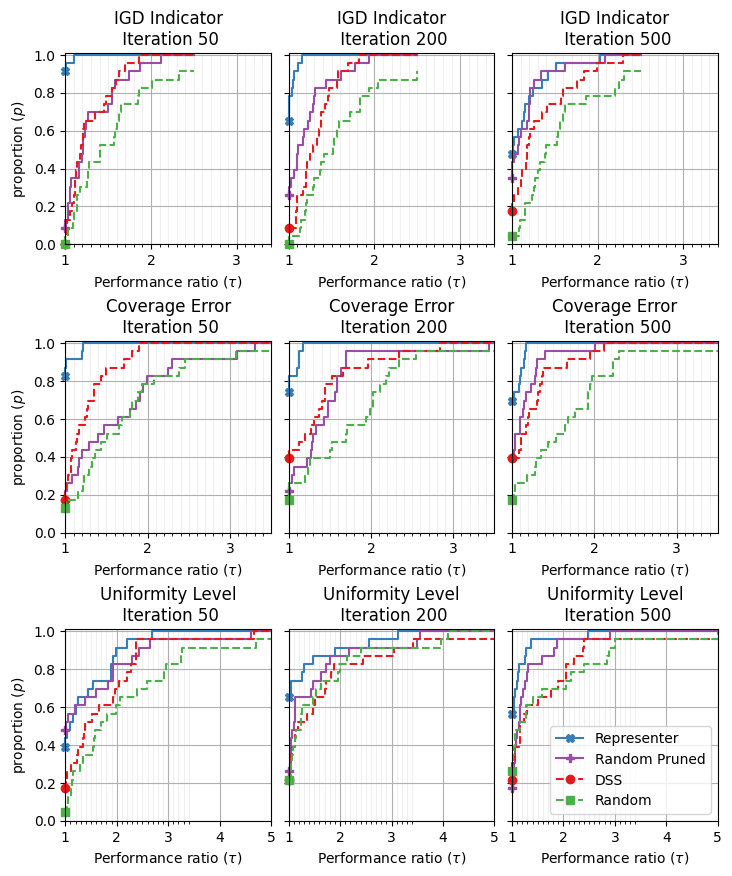

In [7]:
# create a 3 by 3 grid of plots

pt = 1./72.27
width = 347.1235 * pt * 1.5 # in inches

#fig = plt.figure(figsize=(width, width * 5 / 3))
fig, axs = plt.subplots(3, 3, figsize=(width, width*1.2), sharey=True, layout="constrained")

metrics = ["IGD",  "coverage", "uniformity",]
iterations = ["50","200","499"]
xlims = {"IGD": 2.5, "uniformity": 5, "coverage": 3.5}
show_legend = False
show_ylabel = False
for i, metric in enumerate(metrics):
    for j, iteration in enumerate(iterations):
        # if final iteration, show legend
        if iteration == "499" and metric=="uniformity":
            show_legend = True
        else:
            show_legend = False
        if iteration == "50":
            show_ylabel = True
        else:
            show_ylabel = False
        create_ppplot(data, metric, int(iteration), fig=fig, ax=axs[i, j], xlim=xlims[metric], show_legend=show_legend, show_ylabel=show_ylabel)

#fig.savefig("ppplots.pdf", bbox_inches="tight")

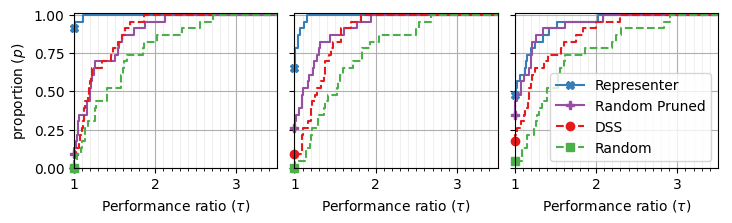

In [13]:
# Only coverage 

# create a 3 by 3 grid of plots

pt = 1./72.27
width = 347.1235 * pt * 1.5 # in inches

#fig = plt.figure(figsize=(width, width * 5 / 3))
fig, axs = plt.subplots(1, 3, figsize=(width, width/3.4), sharey=True, layout="constrained")

metrics = ["IGD"]
iterations = ["50","200","499"]
xlims = {"IGD": 3.5, "uniformity": 5, "coverage": 3.5}
show_legend = False
show_ylabel = False
for i, metric in enumerate(metrics):
    for j, iteration in enumerate(iterations):
        # if final iteration, show legend
        if iteration == "499" and metric=="IGD":
            show_legend = True
        else:
            show_legend = False
        if iteration == "50":
            show_ylabel = True
        else:
            show_ylabel = False
        create_ppplot(data, metric, int(iteration), fig=fig, ax=axs[j], xlim=xlims[metric], show_legend=show_legend, show_ylabel=show_ylabel, show_title=False)

fig.savefig("ppplotsIGDOnly.pdf", bbox_inches="tight")